## Final Project info:

### Goal: to assess the success rate of GMM on modeling systematic error in TESS data and how it supports the recovery of exoplanet transits.

### Background:
The TESS (Transiting Exoplanets Survey Satelite) telescope was estimated to discover hundereds of thousands of exoplanets but due to solar radiation pressure and other systematic effects on the telescope, there is a lot of "jitter" in the light curves resulting from the TESS telescope. This jitter looks very similar to exoplanet transits and therefore has had a significant impact on exoplanet recovery, and only a few thosand exoplanets have been discovered from the TESS telescope itself. In my research we use script which uses a covariance of the light curve itself and a transit modeling method to try and get rid of this systematic error to disover the exoplanet transits. Additionally, contributing a significant hinderance in the retrival of the lightcurves, is the ~3 hour long gaps in the light curve data from downlinks from the TESS telescope to Earth. This is when TESS sends the data to Earth, stopping its data retrival. These gaps do not happen periodically in the sectors, and due to this nature it makes it hard to stich the light cuves together on occasion, and to use a periodic search in the light curves, as variances between the sectors allow for increasing errors in period step size when searching for light curve periods themselves.

### Project idea:

In this project I was inspired by the gaussian mixture modeling and it's extended possibilites of repeated gaussians/higher dimensional models. I want to try and loop through various gaussian sums of these higher possibilities/sin looking functions and then fit each iteration of a step in parameters and then find it's error compared to known exoplanet values/transits. This way, I would be able to test the efficency of this model on real data where we know the results. Then, I would like to try and apply this iterative method to unsearched TESS data (newer years), assuming it has a positive effect at removing the systematic error, to see if we can recover any small transiting exoplanets. In my research, we use what we call "persistant" targets where they have been observed for 10 consecutive sectors so that we can search for periods longer than 28 days (the length of a sector). Overall, I first aim to test the recovery transits of GMM using windowed vectors (because GMM expects a 3d array and we use lightcurve vs time data) on known targets, inherently estimating the systematic error where there is no transit. Then, I would like to use this recovery process on targets which do not have clear transit depth, looping through various modes, to assess the recovery of less clear transits.

In [1]:
#imports
import numpy as np
import pandas as pd
import pickle
import os 
import lightkurve as lk
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, binom, ttest_ind
from scipy import stats
from info import cadence_bounds
from scipy.stats import chi2
from sklearn.mixture import GaussianMixture

/home/juliajos/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/juliajos/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/juliajos/.local/lib/python3.9/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


### Data processing discussion: 

Here, we take a previous used list of TIC IDS "persistant_tids.txt" which contains a list of TIC IDS which are "persistant" or have been consistantly viewed for 8 or more sectors. We do this so we can study long period transits of targets and are not limited to the single 28 day sector when performing our original data search. We also introduce a secondary method for searching these lightcurves through the MAST catalog, which is efficient but does not contain all of the data we use in our research. In this project however, both methods could work as we just use the light curve and the detrended light curve data, although in different formats, both data retrival methods would work. Then, using the MAST catalog, we load in a previously calculated list of TIC ID targets which have already been classified as exoplanets so that we can use them as sources of confirmed exoplanets when performing our search. 

We examine these data types in the following cell to see what their outputs look like.

In [2]:
# our data and catalogs


df = pd.read_csv('persistant_tids.txt', header=None, names=['tic_id'])
tic_ids = df['tic_id'].tolist() #reads out our list of tids

filepath = "TESS/data/light_curves/info/mast_known_eb_catalog.csv"
known_ebs = pd.read_csv(filepath)

In [3]:
#index locations of known exoplanets
print(known_ebs["tess_id"])
mask = np.isin(tic_ids, known_ebs)
indices = np.where(mask)[0]
print(len(indices))
print((indices))

0       185259483
1       307990280
2       387178621
3       300560295
4       318185328
          ...    
4579    318210930
4580    251094451
4581    266958963
4582    375422201
4583    441794509
Name: tess_id, Length: 4584, dtype: int64
82
[  12   58   69   88  112  117  127  128  144  148  172  186  189  208
  216  220  229  231  234  243  252  254  283  285  288  290  325  337
  342  379  385  388  409  422  425  429  433  444  449  450  464  511
  517  560  562  585  586  588  605  636  653  657  658  674  695  711
  716  726  727  743  757  775  802  814  815  842  855  861  877  882
  891  897  916  922  930  932  937  940  968  989  991 1009]


### Accessing a single light curve

Here we walk through the steps to access and plot a single light curve. TID as used in the script is a shorthand version for TIC ID. Tic_ids as used in the script is an array of all of the persistant TIC ID values, taken from persistant_tids.txt. We load in the light curve data indivisually from a previous download by ID, lc_data is the raw lightcurve data, detrend_data is the light curve detrended using the covariance models provided by the TESS telescope itself and the SPOC (center which processes and releases the data). Here, we pick a target from the know exoplanet catalog, load in it's downloaded data, isolate the target for a single sector, and plot the lightcurve data and time as a scatter plot. The light curve data is simply in a value of photon counts at a given timestep (cadence) as retireved from the TESS telescope and therefore has units of FLUX. The time as it is retrieved from the telescope is in units of Barrycentric Tess Julian Date and has step size of the cadence, which changes sometime year to year, but in year 6 (the year we are using) the cadence size is about 2 minutes. 

We can clearly see an example of a transiting "exoplanet" in this example. From previous experience, this model is actually very likely two transiting eclipsing binary stars as evident from the two varying depth transit dips, however the goal of the first search is just to detect transit occurances, and the vetting tests will take into account transit depths (later in the research but not this project) to vet exoplanets versus eclipsing binaries. We can clearly see the flux dip as the target passes in front of the observed star in the graph below.

[10632.207  10659.286  10611.545  ... 10677.9795 10688.113  10706.608 ]


Text(0.5, 1.0, 'Lightcurve')

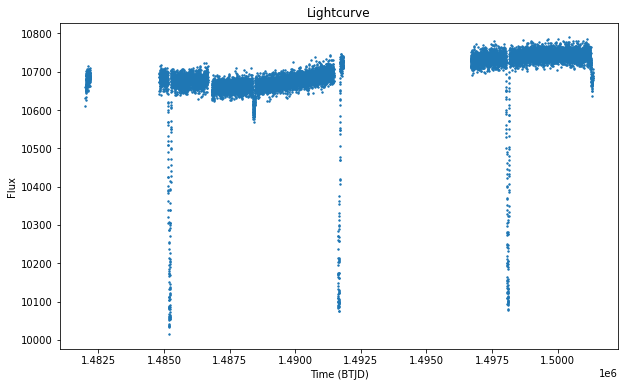

In [4]:
#accessing a single light curve and it's data (using a known target above)

'''
Here we are going to see how well GMM can recover transit points on a known target

tid - stand in for TIC ID (unique number given to each target in TESS)
tic_ids - array of TIC ID values for the targets we want to search
persistant_tids.txt - a text file of TIC IDS which are continuous (they span multiple sectors (here 73 through 83) so that we can search long trends of light curves)

lc_data is the raw lightcurve
lc_detrend is the removed covariances
time_data is in step size cadence and units of BTJD (Barrycentric Tess Julian Date)
'''

#data visualization

tid = tic_ids[285]
lc_data, processed_lc_data, detrend_data, norm_offset, quality_data, time_data, cam_data, ccd_data, coeff_ls, centroid_xy_data, pos_xy_corr = pickle.load(open(os.path.expanduser('TESS/data/light_curves/%s.p' % (tid)), 'rb'))

#lc_sector = np.array(detrend_data[73].unmasked) #processing based on how we downloaded the data
lc_sector = np.array(lc_data[73].unmasked) #processing based on how we downloaded the data

time = np.asarray(time_data[73], dtype=float) # same as above

print(lc_sector) #confirming the data - units of flux

plt.figure(figsize=(10, 6)) 
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux")
plt.scatter(time, lc_sector, s=2)
plt.title("Lightcurve")

### Running GMM on a single target

Here, the original goal of the project was to assess the efficency of GMM in modeling and then predicting transit events in the light curves. Later, we will find that the time it takes for GMM to model the full sector range (73-83) of the light curve versus a single sector makes it very inefficient based off computation time, however effective in part. Here, because GMM expects 3d data, we will use a sliding window vector for each timestamp, we used a 50 point flux value for the window size. As we know this is the location of a transit event, we predict only 2 components to hopefully account for the gaps in the lightcurve due to the downlink gaps. We fit the GMM to the data using previously efficient parameters, fit this GMM and plot the resulting groups of the light curve. 

Assessing visually for now, we see that GMM was very efficient in it's classification for this specific target and specific sector, with the expected transit events clearly marked by the yellow points, while the noise background is aptly modeled in purple.

X shape: (11478, 51)


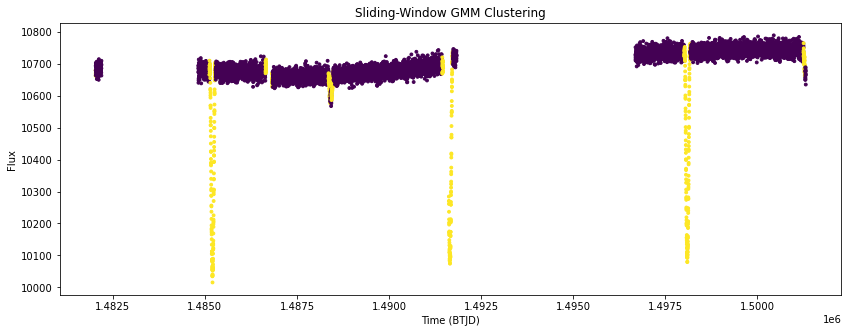

'\nresults: we see that GMM did a really good job at finding the transit in the data here, now that I know it can accurately go through an obvious point I am going to rerun it for different targets\n'

In [5]:
# running GMM on above target

'''
because GMM expects 3d data, we use a sliding window vector for each timestamp (50 point flux used here)
'''

#window params
window = 51        #window size
half = window // 2 #ensures int return
n_components = 2

#building window
# x[i] = flux chunk centered at time[i]
x = np.array([lc_sector[i-half:i+half+1] for i in range(half, len(lc_sector) - half)])

#time values for given x
time_center = time[half:len(time)-half]

print("X shape:", x.shape)   # (n_samples, window_size)

#gmm fit 

gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=5000, tol=1e-5, n_init=10, random_state=42, reg_covar=1e-6)

gmm.fit(x)
labels = gmm.predict(x)

#plotting groups
plt.figure(figsize=(14, 5))
plt.scatter(time_center, lc_sector[half:-half], c=labels, s=8)
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux")
plt.title("Sliding-Window GMM Clustering")
plt.show()

'''
results: we see that GMM did a really good job at finding the transit in the data here, now that I know it can accurately go through an obvious point I am going to rerun it for different targets
'''

### Running GMM on a different target

Now that we have effectively run GMM on our light curve data, we attempt to run it on a less obvious known target, to assess its recovery. Here, we run GMM for 2 components and the for 4 components. When we run these targets without the detrend_lc data, we see that the GMM does not fit the transits well, and tends to group the light curve between the data downlink gaps, and not by the transit (likely due to the sloped tendancies of the light curves). With another known target using the detrended data, the GMM also seems to perform well, moderately, for the transit recovery, as confirmed just visually for now based off the plots. Now that we know that GMM works for multiple known targets, we will try and extend the lightcurve to include all of the sectors for better transit recovery.

X shape: (11203, 51)


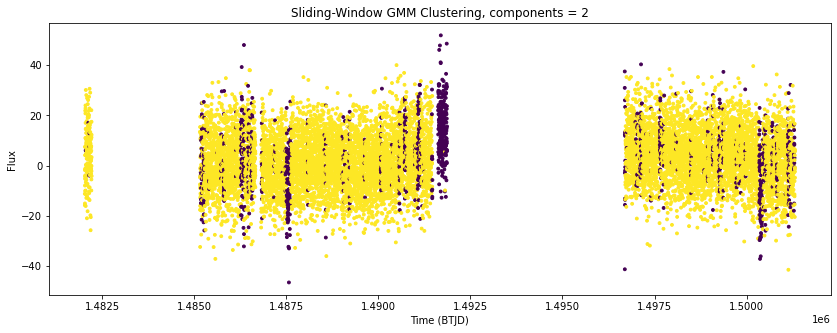

X shape: (11203, 51)


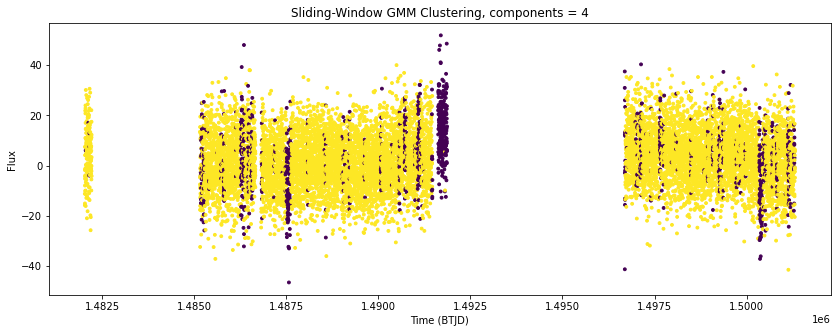

X shape: (11203, 51)


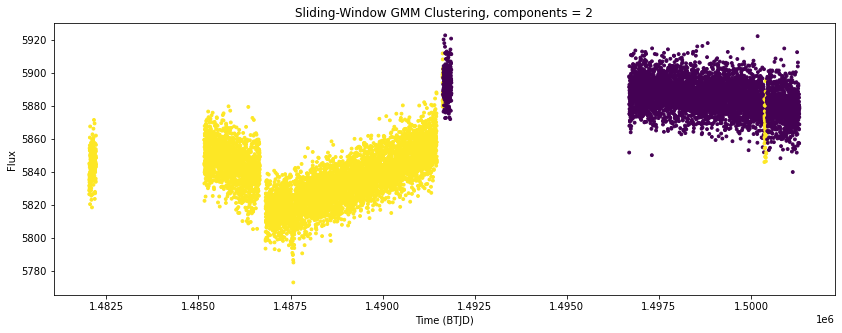

In [6]:
#rerunning for a different target

tid = tic_ids[409]
lc_data, processed_lc_data, detrend_data, norm_offset, quality_data, time_data, cam_data, ccd_data, coeff_ls, centroid_xy_data, pos_xy_corr = pickle.load(open(os.path.expanduser('TESS/data/light_curves/%s.p' % (tid)), 'rb'))
lc_sector = np.array(detrend_data[73].unmasked) #processing based on how we downloaded the data
time = np.asarray(time_data[73], dtype=float) # same as above

'''
note: i am using the lc data and not the detrend data because I want to see how GMM performs when the lightcurve is not detrended
'''

#window params
window = 51        #window size
half = window // 2 #ensures int return
n_components = 2

#building window
# x[i] = flux chunk centered at time[i]
x = np.array([lc_sector[i-half:i+half+1] for i in range(half, len(lc_sector) - half)])

#time values for given x
time_center = time[half:len(time)-half]

print("X shape:", x.shape)   # (n_samples, window_size)

#gmm fit 

gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=5000, tol=1e-5, n_init=10, random_state=42, reg_covar=1e-6)

gmm.fit(x)
labels = gmm.predict(x)

#plotting groups
plt.figure(figsize=(14, 5))
plt.scatter(time_center, lc_sector[half:-half], c=labels, s=8)
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux")
plt.title("Sliding-Window GMM Clustering, components = 2")
plt.show()
plt.close()


n_components = 2

#building window
# x[i] = flux chunk centered at time[i]
x = np.array([lc_sector[i-half:i+half+1] for i in range(half, len(lc_sector) - half)])

#time values for given x
time_center = time[half:len(time)-half]

print("X shape:", x.shape)   # (n_samples, window_size)

#gmm fit 

gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=5000, tol=1e-5, n_init=10, random_state=42, reg_covar=1e-6)

gmm.fit(x)
labels = gmm.predict(x)

#plotting groups
plt.figure(figsize=(14, 5))
plt.scatter(time_center, lc_sector[half:-half], c=labels, s=8)
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux")
plt.title("Sliding-Window GMM Clustering, components = 4")
plt.show()
plt.close()

'''
results:

when I ran this with only 2 components it split the light curve kinda weird

when we run this with 4 components it still splits weird so I will try and get a longer series of data to use
'''

#rerunning for a different target

tid = tic_ids[409]
lc_data, processed_lc_data, detrend_data, norm_offset, quality_data, time_data, cam_data, ccd_data, coeff_ls, centroid_xy_data, pos_xy_corr = pickle.load(open(os.path.expanduser('TESS/data/light_curves/%s.p' % (tid)), 'rb'))
lc_sector = np.array(lc_data[73].unmasked) #processing based on how we downloaded the data
time = np.asarray(time_data[73], dtype=float) # same as above

'''
note: i am using the lc data and not the detrend data because I want to see how GMM performs when the lightcurve is not detrended
'''

#window params
window = 51        #window size
half = window // 2 #ensures int return
n_components = 2

#building window
# x[i] = flux chunk centered at time[i]
x = np.array([lc_sector[i-half:i+half+1] for i in range(half, len(lc_sector) - half)])

#time values for given x
time_center = time[half:len(time)-half]

print("X shape:", x.shape)   # (n_samples, window_size)

#gmm fit 

gmm = GaussianMixture(n_components=n_components, covariance_type='full', max_iter=5000, tol=1e-5, n_init=10, random_state=42, reg_covar=1e-6)

gmm.fit(x)
labels = gmm.predict(x)

#plotting groups
plt.figure(figsize=(14, 5))
plt.scatter(time_center, lc_sector[half:-half], c=labels, s=8)
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux")
plt.title("Sliding-Window GMM Clustering, components = 2")
plt.show()
plt.close()

### Running GMM on all sectors of data

Here, we attempt to run GMM on all 10 sectors of the light curve to see if the transit is better recovered, as sometimes in single sectors the transit event can be unclear. When I tried to run this GMM on all 10 sectors, it took an unreasonably long ammount of time to compute for a single target, yet alone all targets, so I changed it to sectors 73 - 77 just to see GMM's performance. Below, we plot what these sectors of stitched light curve would look like. After, we run the GMM with 4 components (to see what it would do with more components, on the sector stitched light curve. We see that the transit was well recovered, to my surprise, as compared to when we used the raw light curve data.

From here, I do not think that GMM would be feasable to work on all 1000 targets, or even more targets in a future search, as the time it took to look through 5 sectors of a single light curve might not be popssible given my current computing allocations. From here, I was curious about creating a function to assess the accurace of GMM quantively, and possibly assessing other methods of ML for their success.

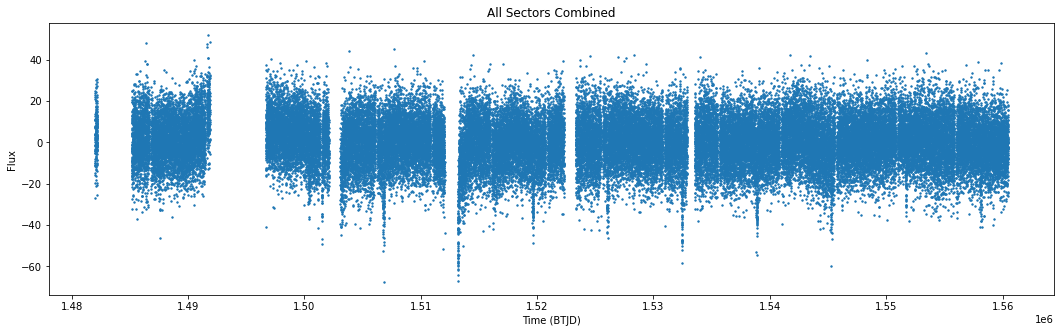

In [7]:
#redoing the data but stitching all of the sector and time data together still for a single target
# we do this to see if GMM performs better on longer dat (my guess is yes due to the weird cuts in the sector downlink gaps), we use detrend data for now

tid = tic_ids[409]
lc_data, processed_lc_data, detrend_data, norm_offset, quality_data, time_data, cam_data, ccd_data, coeff_ls, centroid_xy_data, pos_xy_corr = pickle.load(open(os.path.expanduser('TESS/data/light_curves/%s.p' % (tid)), 'rb'))

all_lc = []
all_time = []

for sector in range(73, 77):
    if detrend_data[sector] is None:
        continue
    try:
        flux = np.asarray(detrend_data[sector].unmasked, dtype=float)
        t = np.asarray(time_data[sector], dtype=float)

        all_lc.append(flux)
        all_time.append(t)
    except:
        continue

all_lc = np.concatenate(all_lc)
all_time = np.concatenate(all_time)

#plotting
plt.figure(figsize=(18,5))
plt.scatter(all_time, all_lc, s=2)
plt.xlabel("Time (BTJD)")
plt.ylabel("Flux")
plt.title("All Sectors Combined")
plt.show()


Windowed x shape: (64730, 51)


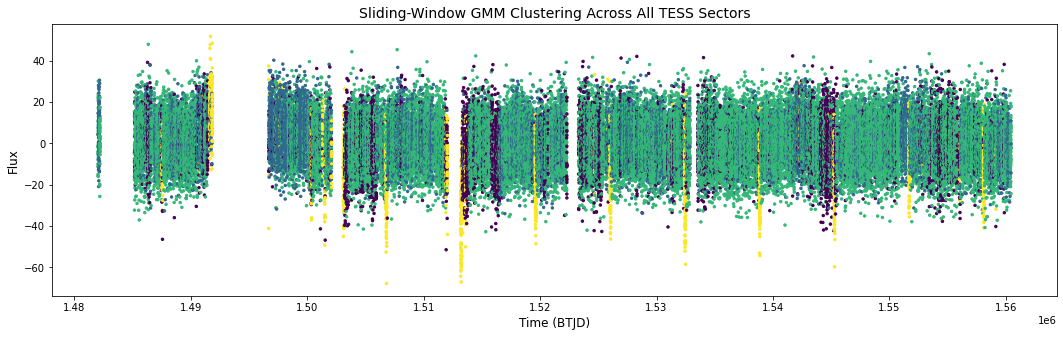

In [8]:
# rerunning GMM with new longer data

window = 51        # sliding window size
half = window // 2 # ensure integer
n_components = 4   # number of GMM clusters


# Each row X[i] = lc_all chunk centered at time_all[i]
x = np.array([
    all_lc[i-half : i+half+1] 
    for i in range(half, len(all_lc) - half)
])

time_center = all_time[half : len(all_time) - half]

print("Windowed x shape:", x.shape)   # (n_samples, 51)


gmm = GaussianMixture( n_components=n_components, covariance_type='full', max_iter=5000, tol=1e-5, n_init=10, random_state=42, reg_covar=1e-6)

gmm.fit(x)
labels = gmm.predict(x)

#plotting
plt.figure(figsize=(18, 5))
plt.scatter(time_center, all_lc[half:-half], c=labels, s=6)
plt.xlabel("Time (BTJD)", fontsize=12)
plt.ylabel("Flux", fontsize=12)
plt.title("Sliding-Window GMM Clustering Across All TESS Sectors", fontsize=14)
plt.show()

### Plotting known transit locations and baseline locations

Here, we loop through a few of the targets in the known transit list and the full list of TIC IDS so we visually can pick out some of the points of very obvious transits and obvious baseline targets with no transits for training of future ML models. A summary of the targets chosen is listed after the graphing portion.

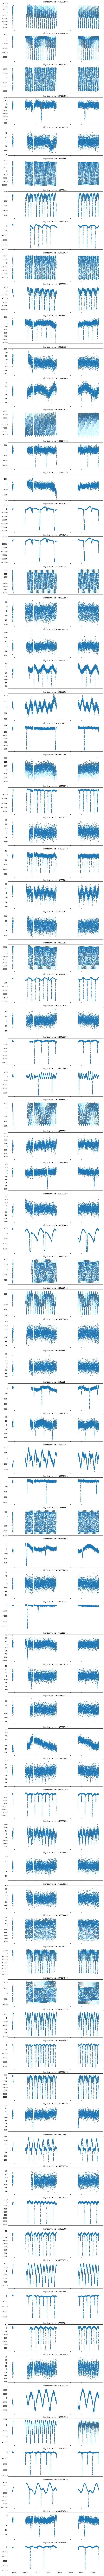

In [9]:
# Plot all known targets in the same figure as subplots

fig, axs = plt.subplots(len(indices), 1, figsize=(10, 3 * len(indices)), sharex=True)

for ax, idx in zip(axs, indices):
    tid = tic_ids[idx]
    lc_data, processed_lc_data, detrend_data, norm_offset, quality_data, time_data, cam_data, ccd_data, coeff_ls, centroid_xy_data, pos_xy_corr = pickle.load(open(os.path.expanduser(f'TESS/data/light_curves/{tid}.p'), 'rb'))

    lc_sector = np.array(detrend_data[73].unmasked)
    time = np.asarray(time_data[73], dtype=float)

    ax.scatter(time, lc_sector, s=2)
    ax.set_title(f"Lightcurve, tid={tid}")

plt.tight_layout()
plt.show()

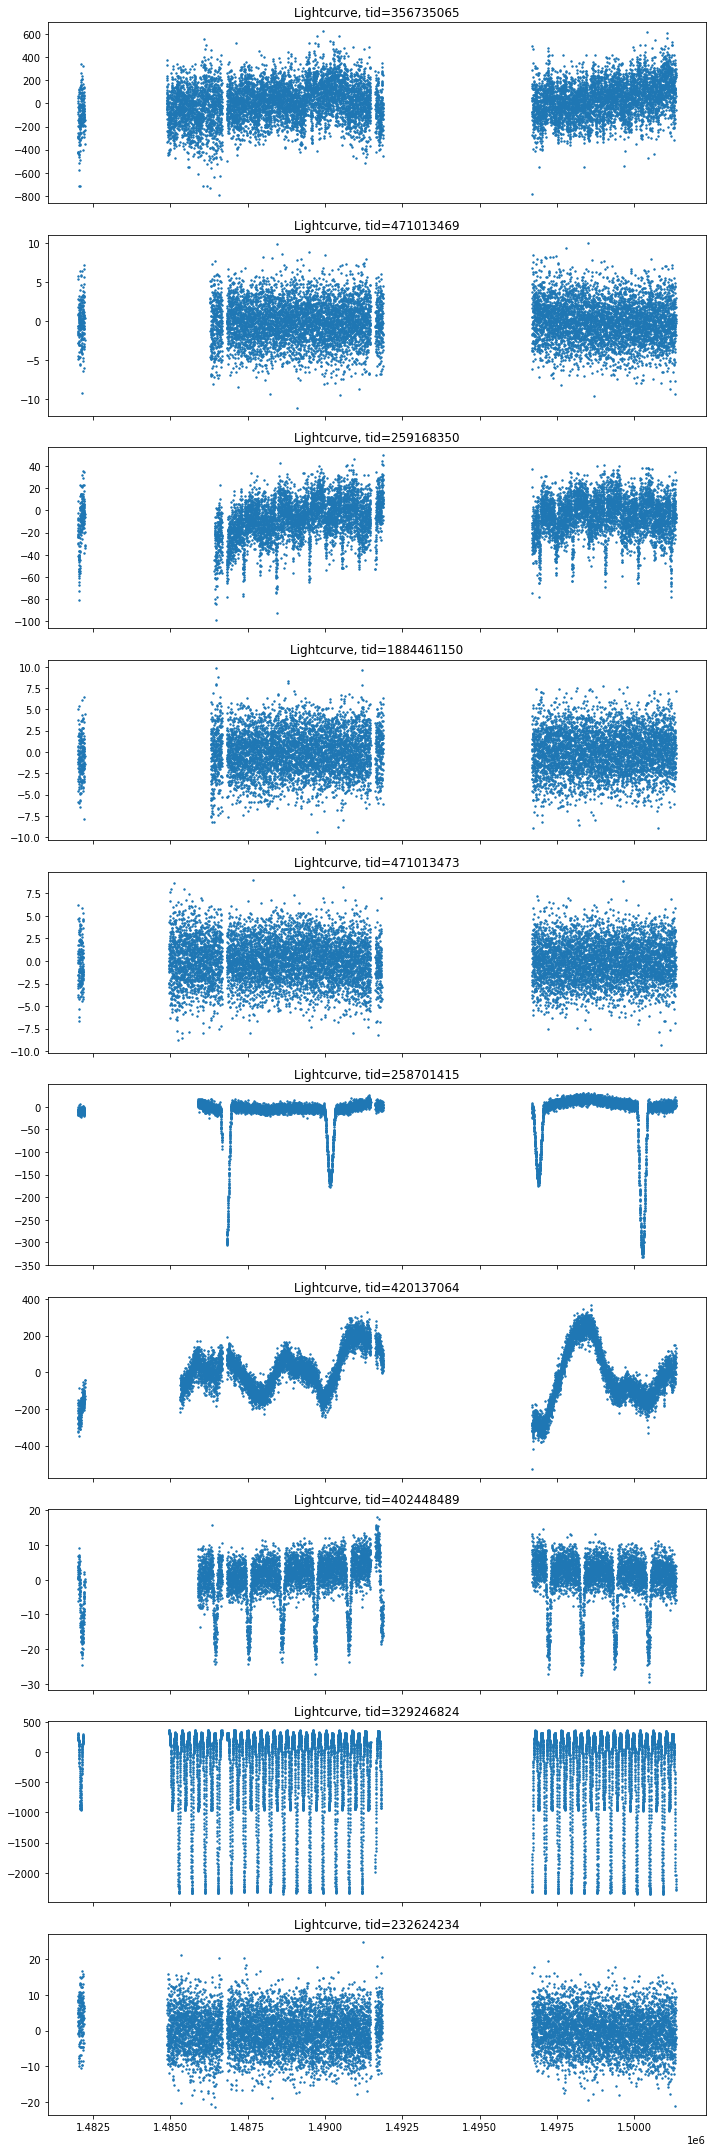

In [10]:
# Searching for baseline points without transits – all plots in one figure

subset = tic_ids[50:60]

fig, axs = plt.subplots(len(subset), 1, figsize=(10, 3 * len(subset)), sharex=True)

for ax, tid in zip(axs, subset):
    lc_data, processed_lc_data, detrend_data, norm_offset, quality_data, time_data, cam_data, ccd_data, coeff_ls, centroid_xy_data, pos_xy_corr = pickle.load(open(os.path.expanduser(f"TESS/data/light_curves/{tid}.p"), "rb"))

    lc_sector = np.array(detrend_data[73].unmasked)
    time = np.asarray(time_data[73], dtype=float)

    ax.scatter(time, lc_sector, s=2)
    ax.set_title(f"Lightcurve, tid={tid}")

plt.tight_layout()
plt.show()


# TID targets selected from the graphs
Known targets:
237117591
199688409
229910746
420114772
320524751
259006185
356896561
441794509

Transit?
229451831

Baseline targets:
232611919
1551706194
230129753
471013469
1884461150


### Function for detecting transits

Here, we first create a function to detect transits found within the GMM search. We do this by running the GMM with 2 components (as we saw that it still pulled out the transit event in the example before). I tried to run this with 4 components, but it took too long to be feasable for the results of this project. Once we have run the GMM sample on the target, we find the median value of each cluster, and take the transiting cluster to be the cluster with the smallest median. Then, we take the cluster with the largest median as the baseline of the flux. From there, we create a label for trhe transit mask, labeling which windows are contained with the transit, and find the fration of time points that look like a transit. We find the flux of the given clusters (transit and baseline), and use the median absolute deviaiton to calculate the sigma from the baseline. I originally tried to calculate this by taking flux windows but the transits are so close together this resulted in sigmas that were way too short. We set sigma > 2 as a transit detection to assess performance for now.


We take the known transit locations we found above, we loop through these targets in the detect transit function and plot the results of the clustering of the light curve. After lots of tweaking and adjusting the median calculation, we find that GMM correctly predicts all of the known transit events and correctly predicts the baseline points, based on their standard deviation values.

Detection Results
TIC ID       In Catalog   Detected   Fraction   Depth σ    Status    

Known transiting TIC IDS:
237117591    Yes          1          0.233      3.67       true positive
199688409    Yes          1          0.240      5.74       true positive
229910746    Yes          1          0.170      5.97       true positive
420114772    Yes          1          0.049      4.66       true positive
320524751    Yes          1          0.052      3.80       true positive
259006185    Yes          1          0.083      6.43       true positive
356896561    Yes          1          0.228      12.45      true positive
441794509    Yes          1          0.062      3.75       true positive

Non-catalog targets:
236785664    No           0          0.196      0.18       true negative 
326209538    No           0          0.947      0.18       true negative 
1400895491   No           0          0.772      0.18       true negative 
1884094468   No           0          0.307      0.07     

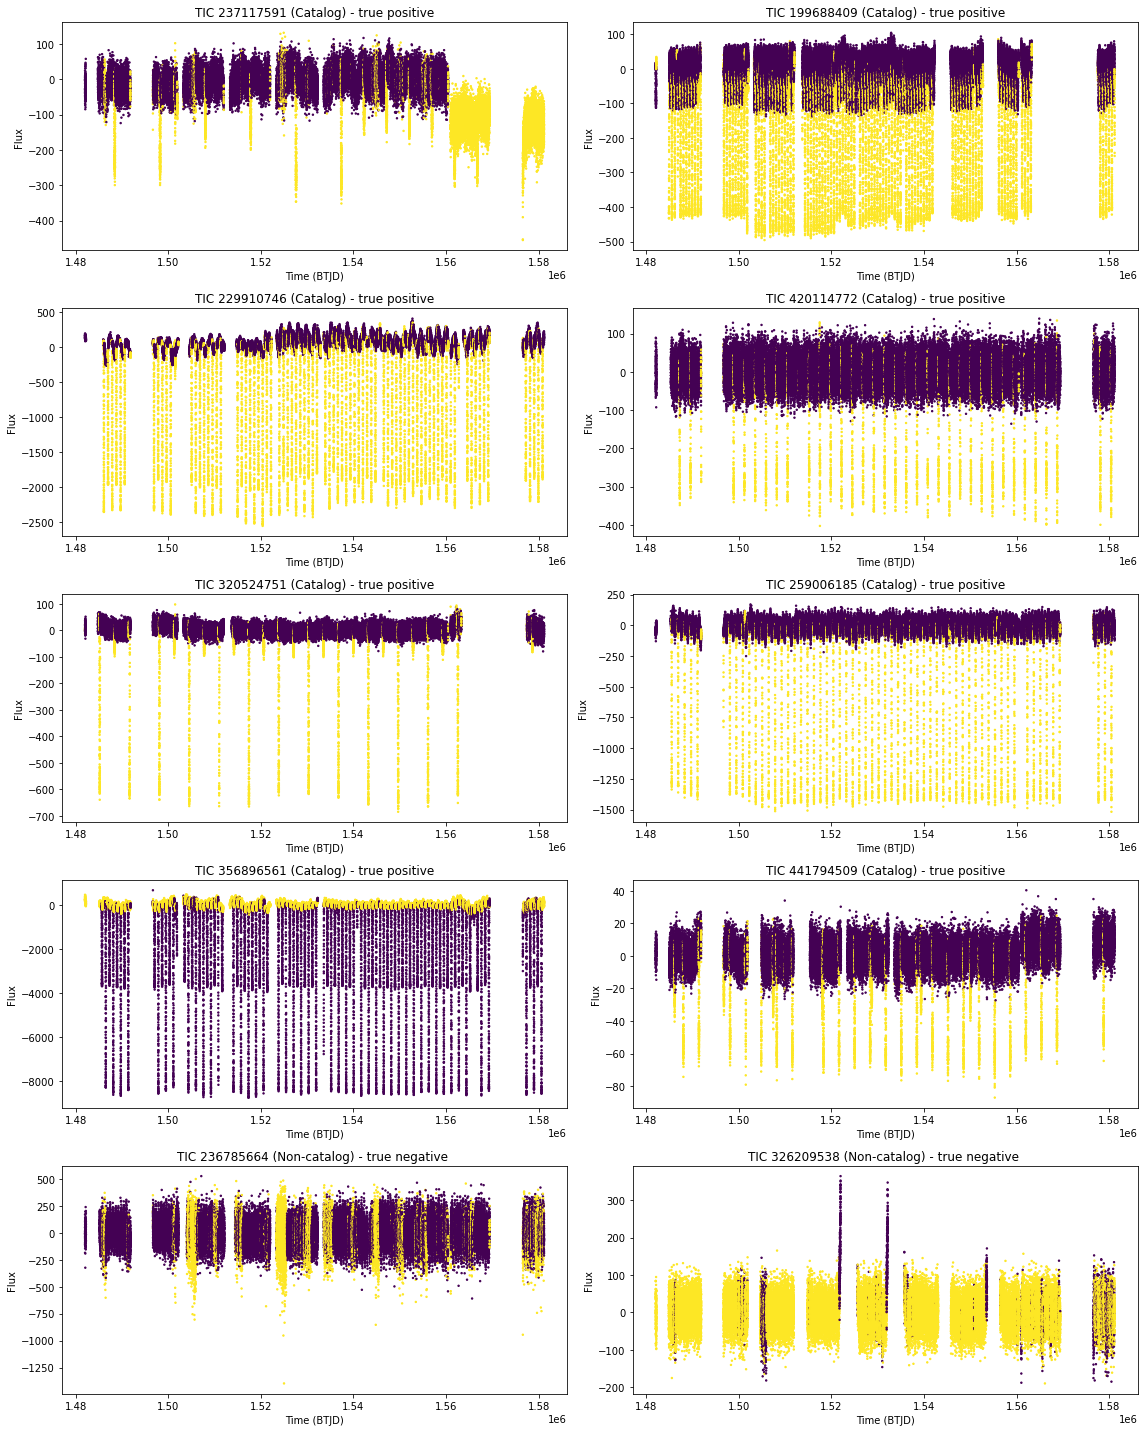

summary stats:
Known transits detected: 8/8 (100.0%)
Non-transits correctly rejected: 18/19 (94.7%)

True Positives: 8
False Negatives: 0
False Positives: 1
True Negatives: 18

Precision: 0.889
Recall: 1.000


In [11]:
#attempting to write a function that flags the detection location of the GMM transit events from many targets

def detect_transit_gmm(lc_sector, threshold_fraction=0.15):
    """
    Detect if a transit exists using GMM
    """
    # Same gmm parameters as before
    # Create windows
    window = 51
    half = window // 2
    x = np.array([lc_sector[i-half:i+half+1] 
                  for i in range(half, len(lc_sector) - half)])
    
    gmm = GaussianMixture(n_components=2, covariance_type='full', 
                         max_iter=5000, tol=1e-5, n_init=10, 
                         random_state=42, reg_covar=1e-6)
    gmm.fit(x)
    labels = gmm.predict(x)
    
    # Find transit cluster (lower flux)
    cluster_medians = [np.median(lc_sector[half:-half][labels == c]) for c in range(2)] #identifying median of each GMM cluster
    transit_cluster = np.argmin(cluster_medians) # labeling transit by smallest cluster median
    baseline_cluster = np.argmax(cluster_medians) #labeling basline as max cluster median
    
    #stats
    transit_mask = (labels == transit_cluster) #what windows are transit windows
    transit_fraction = np.sum(transit_mask) / len(labels) #fraction time points that look like a transit
    
    baseline_flux = cluster_medians[baseline_cluster] #flux given clusters
    transit_flux = cluster_medians[transit_cluster] #transit flux given clusters
    
    #depths 
    vals = lc_sector[half:-half]
    # Use only baseline windows
    baseline_vals = vals[labels == baseline_cluster]

    #mad for sigma
    mad = np.median(np.abs(baseline_vals - np.median(baseline_vals)))
    sigma = 1.4826 * mad if mad > 0 else np.std(baseline_vals) #k = 1.4826 from conversion between MAD and sigma

    depth_ratio = abs(baseline_flux - transit_flux) / sigma

    # Detection criteria
    has_transit =(depth_ratio > 2) #sigma depth > 2 mark as transit
    
    return has_transit, transit_fraction, depth_ratio, labels, half


#testing on multiple targets
print("Detection Results")
print(f"{'TIC ID':<12} {'In Catalog':<12} {'Detected':<10} {'Fraction':<10} {'Depth σ':<10} {'Status':<10}")
detections = []

#Testing on known transiting events
print("\nKnown transiting TIC IDS:")
fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()
plot_idx = 0

train_transit_tids = [237117591, 199688409, 229910746, 420114772, 320524751, 259006185, 356896561, 441794509] #known transit locations
train_non_transit_tids = [232611919, 1551706194, 230129753, 471013469, 1884461150] # known baseline

#looping through known targets
for tid in train_transit_tids:
    try:
        lc_data, _, detrend_data, _, _, time_data, *rest = pickle.load(
            open(os.path.expanduser('TESS/data/light_curves/%s.p' % tid), 'rb'))
        
        # using multiple sectors
        all_lc = []
        all_time = []
        for sector in range(73, 78):
            if detrend_data[sector] is None:
                continue
            try:
                flux = np.asarray(detrend_data[sector].unmasked, dtype=float)
                t = np.asarray(time_data[sector], dtype=float)
                all_lc.append(flux)
                all_time.append(t)
            except:
                continue
        
        if len(all_lc) == 0:
            continue
        
        lc_sector = np.concatenate(all_lc)
        time = np.concatenate(all_time)
        
        # getting detected sectors from gmm
        has_transit, frac, depth_sig, labels, half = detect_transit_gmm(lc_sector)
        time_center = time[half:-half]
        
        detections.append({
            'tid': tid,
            'in_catalog': True,
            'detected': has_transit,
            'fraction': frac,
            'depth_sigma': depth_sig
        })
        
        status = "true positive" if has_transit else "false negative"
        print(f"{tid:<12} {'Yes':<12} {has_transit:<10} {frac:<10.3f} {depth_sig:<10.2f} {status:<10}")
        
        # Plot
        ax = axes[plot_idx]
        ax.scatter(time_center, lc_sector[half:-half], c=labels, s=2, cmap='viridis')
        ax.set_xlabel("Time (BTJD)")
        ax.set_ylabel("Flux")
        ax.set_title(f"TIC {tid} (Catalog) - {status}")
        plot_idx += 1
        
    except Exception as e:
        print(f"{tid:<12} failed: {e}")
        continue

#testing on targets not in known range
print("\nNon-catalog targets:")
tested_non_catalog = 0
for i in range(len(tic_ids[60:80])):
    if i in indices:
        continue
    
    if plot_idx >= 15:
        break
    
    tid = tic_ids[i]
    
    try:
        lc_data, _, detrend_data, _, _, time_data, *rest = pickle.load(
            open(os.path.expanduser('TESS/data/light_curves/%s.p' % tid), 'rb'))
        
        # Stitch sectors
        all_lc = []
        all_time = []
        for sector in range(73, 78):
            if detrend_data[sector] is None:
                continue
            try:
                flux = np.asarray(detrend_data[sector].unmasked, dtype=float)
                t = np.asarray(time_data[sector], dtype=float)
                all_lc.append(flux)
                all_time.append(t)
            except:
                continue
        
        if len(all_lc) == 0:
            continue
        
        lc_sector = np.concatenate(all_lc)
        time = np.concatenate(all_time)
        
        # Detect transit
        has_transit, frac, depth_sig, labels, half = detect_transit_gmm(lc_sector)
        time_center = time[half:-half]
        
        detections.append({
            'tid': tid,
            'in_catalog': False,
            'detected': has_transit,
            'fraction': frac,
            'depth_sigma': depth_sig
        })
        
        status = "false positive" if has_transit else "true negative "
        print(f"{tid:<12} {'No':<12} {has_transit:<10} {frac:<10.3f} {depth_sig:<10.2f} {status:<10}")
        
        # Plot
        ax = axes[plot_idx]
        ax.scatter(time_center, lc_sector[half:-half], c=labels, s=2, cmap='viridis')
        ax.set_xlabel("Time (BTJD)")
        ax.set_ylabel("Flux")
        ax.set_title(f"TIC {tid} (Non-catalog) - {status}")
        plot_idx += 1
        
        tested_non_catalog += 1
        
    except Exception as e:
        continue

plt.tight_layout()
plt.show()

# Summary statistics
detections_df = pd.DataFrame(detections)

catalog_targets = detections_df[detections_df['in_catalog'] == True]
non_catalog_targets = detections_df[detections_df['in_catalog'] == False]

tp = np.sum(catalog_targets['detected']) #true positive
fn = np.sum(~catalog_targets['detected']) #false negative
fp = np.sum(non_catalog_targets['detected']) #false positive
tn = np.sum(~non_catalog_targets['detected']) #true negative

print("summary stats:")
print(f"Known transits detected: {tp}/{len(catalog_targets)} ({tp/len(catalog_targets)*100:.1f}%)")
print(f"Non-transits correctly rejected: {tn}/{len(non_catalog_targets)} ({tn/len(non_catalog_targets)*100:.1f}%)")
print(f"\nTrue Positives: {tp}")
print(f"False Negatives: {fn}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"\nPrecision: {tp/(tp+fp) if (tp+fp)>0 else 0:.3f}")
print(f"Recall: {tp/(tp+fn) if (tp+fn)>0 else 0:.3f}")

### Running on unknown targets

We see that running this method on unknown targets produces, generallly, what we would expect. When there is large variance in the light curve after the detrending, will two groups allowed, gmm tends to group the differing sections and not the transit events. Additionally, there are some targets we plotted that should be flagged by eye, however, they do not reach the threshold we set previously. These thresholds are in place to reduce error, so I am sure in the future with more effort that these specifics could be modified and optimized. Overall however, we see that this method was very efficient for modeling the baseline and the transits, as a simple test of efficieny and if it would work to model transit events.

TIC 1400879279 - Detected: False, Fraction: 0.264, Depth σ: 0.00
TIC 233089202 - Detected: True, Fraction: 0.329, Depth σ: 2.06
TIC 353734834 - Detected: False, Fraction: 0.251, Depth σ: 0.06
TIC 264220850 - Detected: False, Fraction: 0.409, Depth σ: 0.07
TIC 229583029 - Detected: False, Fraction: 0.447, Depth σ: 0.11
TIC 1201369268 - Detected: False, Fraction: 0.288, Depth σ: 0.06
TIC 233625787 - Detected: False, Fraction: 0.193, Depth σ: 0.25
TIC 219898046 - Detected: False, Fraction: 0.174, Depth σ: 0.17
TIC 1401022655 - Detected: False, Fraction: 0.605, Depth σ: 0.01
TIC 198240449 - Detected: False, Fraction: 0.138, Depth σ: 0.09


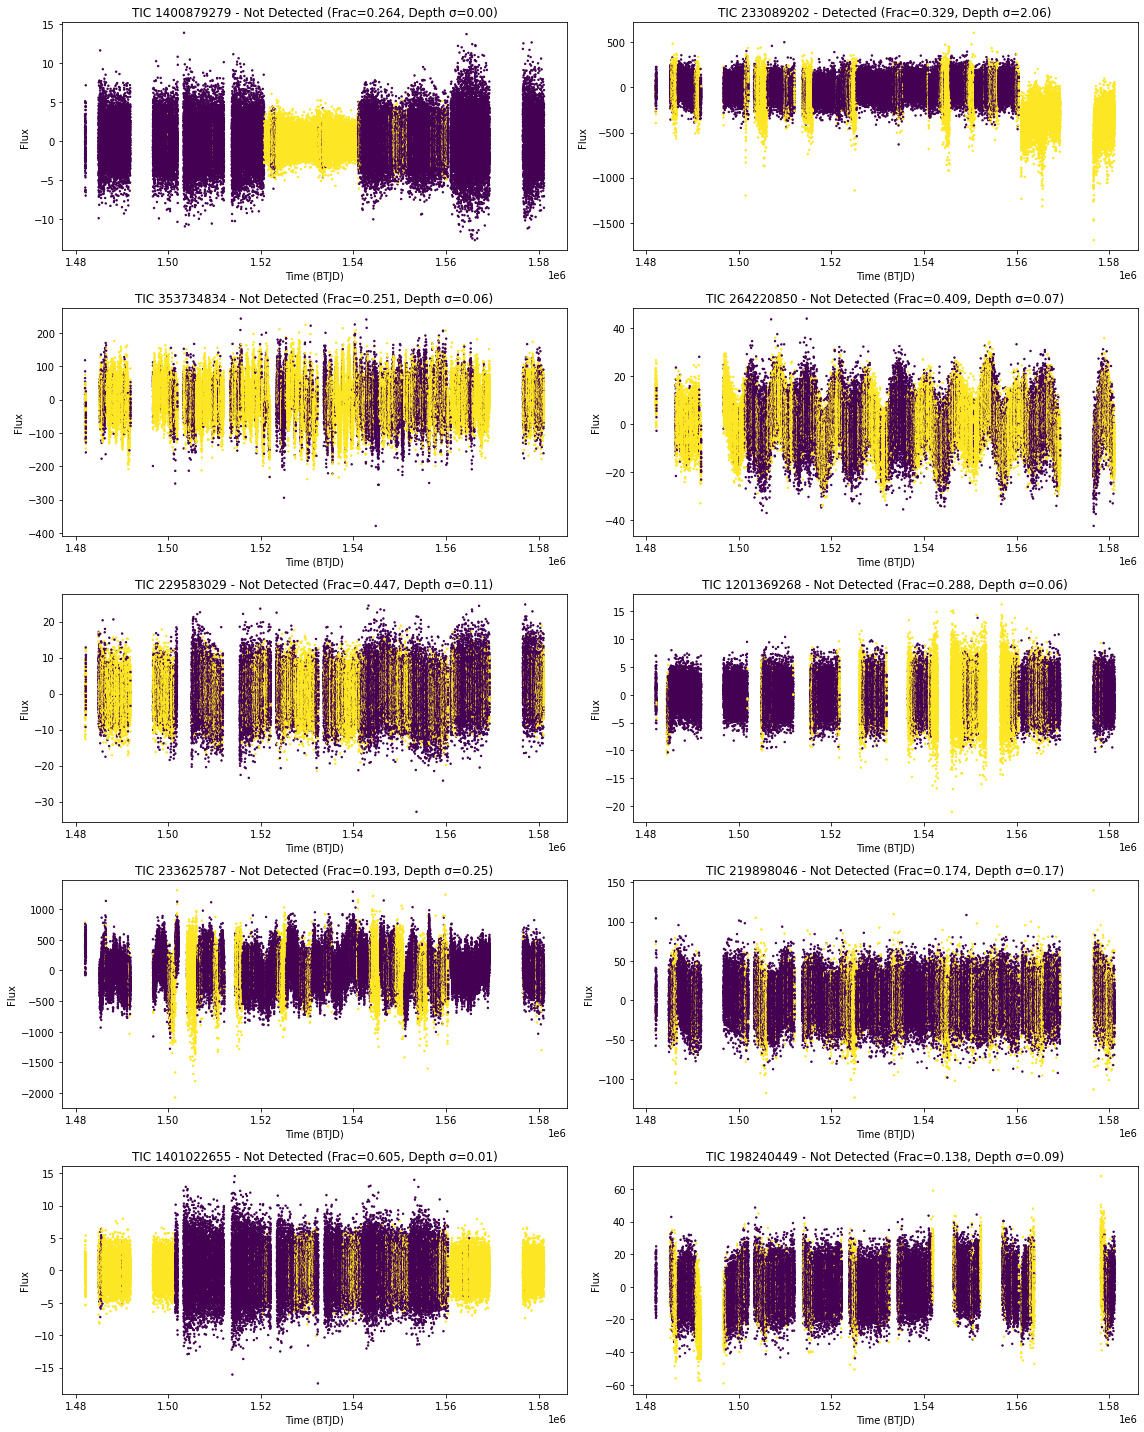

In [12]:
#testing methods on unknown targets
def detect_and_plot_unknown_targets(tic_ids, sectors=range(73,78), max_plots=10):
    """
    Apply GMM transit detection to unknown targets and plot results.

    """
    detections_unknown = []
    plotted = 0
    
    # Setup plotting
    n_rows = (max_plots + 1) // 2
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 4*n_rows))
    axes = axes.flatten()
    
    for tid in tic_ids:
        try:
            lc_data, _, detrend_data, _, _, time_data, *rest = pickle.load(
                open(os.path.expanduser(f'TESS/data/light_curves/{tid}.p'), 'rb'))
            
            all_lc, all_time = [], []
            for sector in sectors:
                if detrend_data[sector] is None:
                    continue
                try:
                    flux = np.asarray(detrend_data[sector].unmasked, dtype=float)
                    t = np.asarray(time_data[sector], dtype=float)
                    all_lc.append(flux)
                    all_time.append(t)
                except:
                    continue
            
            if len(all_lc) == 0:
                continue
            
            lc_sector = np.concatenate(all_lc)
            time = np.concatenate(all_time)
            
            has_transit, frac, depth_sig, labels, half = detect_transit_gmm(lc_sector)
            time_center = time[half:-half]
            
            detections_unknown.append({
                'tid': tid,
                'detected': has_transit,
                'fraction': frac,
                'depth_sigma': depth_sig
            })
            
            # Plot first max_plots targets
            if plotted < max_plots:
                ax = axes[plotted]
                ax.scatter(time_center, lc_sector[half:-half], c=labels, s=2, cmap='viridis')
                ax.set_xlabel("Time (BTJD)")
                ax.set_ylabel("Flux")
                status = "Detected" if has_transit else "Not Detected"
                ax.set_title(f"TIC {tid} - {status} (Frac={frac:.3f}, Depth σ={depth_sig:.2f})")
                plotted += 1
            
            print(f"TIC {tid} - Detected: {has_transit}, Fraction: {frac:.3f}, Depth σ: {depth_sig:.2f}")
        
        except Exception as e:
            print(f"TIC {tid} failed: {e}")
            continue
    
    plt.tight_layout()
    plt.show()
    
    return detections_unknown

unknown_tic_ids = tic_ids[100:110]  # Replace with your unknown targets
detections_unknown = detect_and_plot_unknown_targets(unknown_tic_ids, sectors=range(73,78), max_plots=10)

### results:

The goal of this project was originally to try and assess the detection of exoplanet transits using GMM, training first with known targets, and then applying it to our unsearched targets, which likely do not contain transits in many targers (transits often found at about 0.5% of the time from all targets). Visually, we can see that GMM worked well first on an obvious transit target, and then again on a second target with a transit depth that is not as deep. Then, using GMM on multiple sectors still for a single target, we see that it performed well, isolating the transit event from the baseline noise. We saw, however, that to run GMM on a single target for even 5 sectors took a very long time, making it an infesable method to perform a search on all targets for all sectors. From here, I was curious to test the detection of GMM on known targets, and try to apply it to unknown targets, and due to the time GMM took, attempt to apply other machine learning methods we learned in class like nearest neighbors, support vector machines, and fandom forest. 

We made a detection function that uses the depth of the GMM transits, using the median absolute deviation of the transit events compared to the baseline, using sigma = 2 as the detection threshold. We found this to be very efficient, with a 100% success rate in detecting the known detection targets as well as a 94% detection rate for the non transit baseline targets. The development of this function and method to loop through many targets with our specific type of data took a while, I spent a long time too attepting to develop a method to apply our data to other machine learning methods as previously described, however, these methods took too long to run and were also not feasable for the scope of this project. 

With more effort, I would be interested to see how these systems perform with better allocated resources, for example, I left the n components = 2 for the GMM because anything over that took too much time for the scope of the project. I would be curious to see the transit results if I could add more components here. I would also be interested to see if we could get GMM to detect the seperate transits of elciping binaries, or if we apply harder sigma thresholds how it would effect the detection rate of the transits.

All in all, we learned that GMM can very efficiently model transit profiles for light curves coming from the TESS telescope. GMM very efficiently models stiched light curves ( in our case 5 consecutive sectors) of light curve data, and predicted with 100% accuracy all of the known transit targets we gave the model. This model also predicted with 94% accuracy our baseline points, confirming its accuracy for both types of light curves. We go on to apply this method to targets where we do not know its classification, detecting only 1/10 light curves as a transit, however, this result makes sense as we only expect to see a transit 0.5% of the time. 

I was suprised at the efficiency of GMM to model transits, as our method is a lot more complex, however, we are only modeling transit events here and not other aspects of the exoplanet orbit like its period or linearly predicting the orbit itself. We see visually, however, even while using the detrended data, GMM still classifies some long term trends as a part of the transit event (in the case of the one detection we had above). Secondly, we see that very small sigma transits, that we likely would classify by eye, were not flagged, due to their small sigma values. With mmore effort, or with GMM combined with other methods, we likely could improve these detection statistics.